In [1]:
!pip install opencv-python matplotlib

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [104]:
print("Upload bandage PNG")
uploaded = files.upload()

bandage_path = list(uploaded.keys())[0]

# IMPORTANT → keep alpha channel
bandage = cv2.imread(bandage_path, cv2.IMREAD_UNCHANGED)

print("Bandage shape:", bandage.shape)

Upload bandage PNG


Saving bandage.png to bandage (4).png
Bandage shape: (360, 402, 4)


In [67]:
def detect_wound(img):

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower1 = np.array([0,120,70])
    upper1 = np.array([10,255,255])
    lower2 = np.array([170,120,70])
    upper2 = np.array([180,255,255])

    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)

    red = mask1 + mask2

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150)

    mask = cv2.bitwise_and(red, edges)

    kernel = np.ones((3,3),np.uint8)
    mask = cv2.dilate(mask,kernel,1)

    return mask


In [106]:
def get_wound(mask,img):

    contours,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    if len(contours)==0:
        return None

    best=None
    best_score=0
    img_area=img.shape[0]*img.shape[1]

    for c in contours:

        area=cv2.contourArea(c)
        if area<40 or area>img_area*0.01:
            continue

        x,y,w,h=cv2.boundingRect(c)
        ratio=max(w,h)/(min(w,h)+1)

        # redness validation
        mask_temp=np.zeros(img.shape[:2],dtype=np.uint8)
        cv2.drawContours(mask_temp,[c],-1,255,-1)

        mean=cv2.mean(img,mask=mask_temp)
        red=mean[2]
        green=mean[1]

        # must be reddish
        if red < green+20:
            continue

        per=cv2.arcLength(c,True)

        score = ratio*4 + per*0.05 - area*0.002

        if score>best_score:
            best_score=score
            best=c

    if best is None:
        return None

    rect=cv2.minAreaRect(best)
    (cx,cy),(w,h),angle=rect

    if w<h:
        angle+=90

    length=max(w,h)

    return int(cx),int(cy),length,angle

In [74]:
def transform_bandage(bandage,length,angle,img,cx,cy):

    scale=max(0.6, length/bandage.shape[1]*0.9)
    bandage=cv2.resize(bandage,None,fx=scale,fy=scale)

    bh,bw=bandage.shape[:2]

    M=cv2.getRotationMatrix2D((bw//2,bh//2),angle,1)
    bandage=cv2.warpAffine(
        bandage,M,(bw,bh),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_TRANSPARENT
    )

    # brightness match
    skin=img[cy,cx]
    brightness=np.mean(skin)/255
    bandage[:,:,:3]=(bandage[:,:,:3]*brightness).astype(np.uint8)

    # smooth edges
    bandage[:,:,3]=cv2.GaussianBlur(bandage[:,:,3],(7,7),0)

    return bandage.astype(np.uint8)

In [70]:
def overlay(bg,fg,x,y):

    h,w=fg.shape[:2]

    x1,y1=max(x,0),max(y,0)
    x2,y2=min(x+w,bg.shape[1]),min(y+h,bg.shape[0])

    fg_x1=x1-x
    fg_y1=y1-y
    fg_x2=fg_x1+(x2-x1)
    fg_y2=fg_y1+(y2-y1)

    alpha=fg[fg_y1:fg_y2,fg_x1:fg_x2,3]/255.0

    for c in range(3):
        bg[y1:y2,x1:x2,c]=(
            alpha*fg[fg_y1:fg_y2,fg_x1:fg_x2,c]
            +(1-alpha)*bg[y1:y2,x1:x2,c]
        )

    return bg



In [71]:
print("Upload 3 arm images")
uploaded = files.upload()

paths = list(uploaded.keys())

Upload 3 arm images


Saving hand1.jpg to hand1 (4).jpg
Saving hand3.jpg to hand3 (6).jpg
Saving hand.webp to hand (9).webp


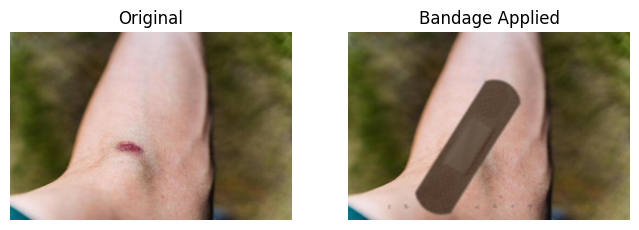

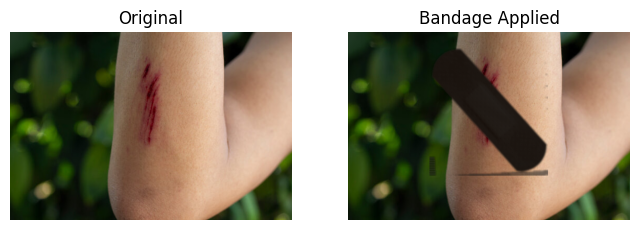

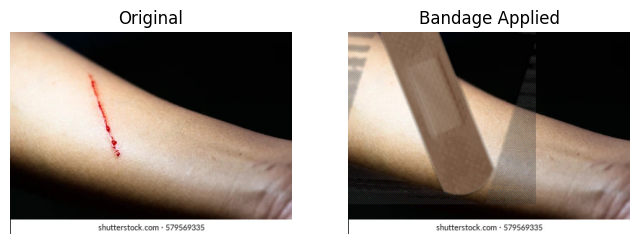

In [107]:
for path in paths:

    img=cv2.imread(path)
    original=img.copy()

    mask=detect_wound(img)
    props=get_wound(mask,img)

    if props is None:
        print("No wound detected:",path)
        continue

    cx,cy,length,angle=props

    bnd=transform_bandage(bandage.copy(),length,angle,img,cx,cy)

    x=int(round(cx-bnd.shape[1]/2))
    y=int(round(cy-bnd.shape[0]/2))

    result=overlay(img,bnd,x,y)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original,cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Bandage Applied")
    plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()